In [1]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML Parkinsons Project/parkinsons.data")

Mounted at /content/drive


In [2]:
import random
from sklearn.preprocessing import StandardScaler

data['subject_id'] = data['name'].apply(lambda x: x.split("_")[2])
subjects = data['subject_id'].unique()
random.seed(42)
random.shuffle(subjects)

# Split data into train, val, test (70%, 15%, 15%)
train = subjects[0 : 22]
validation = subjects[22 : 27]
test = subjects[27 : 32]

train_df = data[data['subject_id'].isin(train)].reset_index(drop=True)
validation_df = data[data['subject_id'].isin(validation)].reset_index(drop=True)
test_df = data[data['subject_id'].isin(test)].reset_index(drop=True)

print("Train subjects:", len(train_df['subject_id'].unique()))
print("Validation subjects:", len(validation_df['subject_id'].unique()))
print("Test subjects:", len(test_df['subject_id'].unique()))

# Split dataframes into features and labels
x_train = train_df.drop(["name", "status", "subject_id"], axis=1)
y_train = pd.DataFrame().assign(status=train_df["status"])

x_val = validation_df.drop(["name", "status", "subject_id"], axis=1)
y_val = pd.DataFrame().assign(status=validation_df["status"])

x_test = test_df.drop(["name", "status", "subject_id"], axis=1)
y_test = pd.DataFrame().assign(status=test_df["status"])

# Use standard scaler on data
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)



Train subjects: 22
Validation subjects: 5
Test subjects: 5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


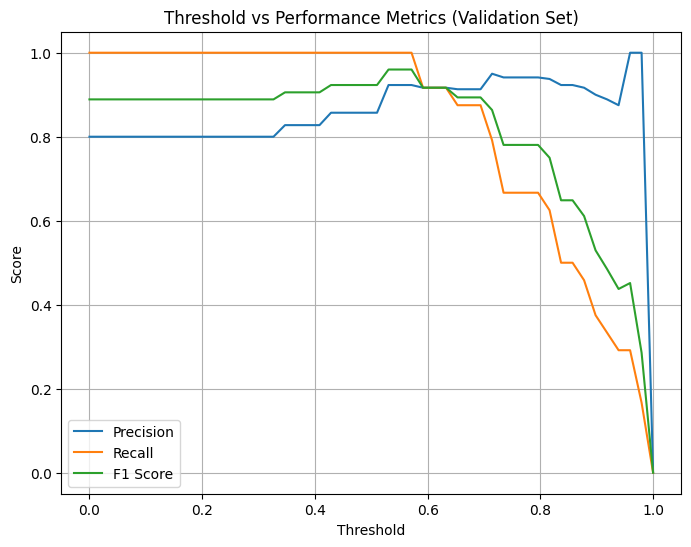

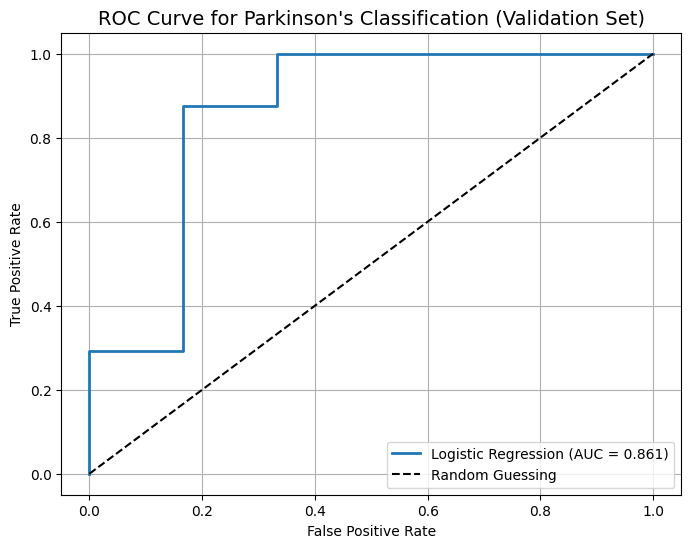

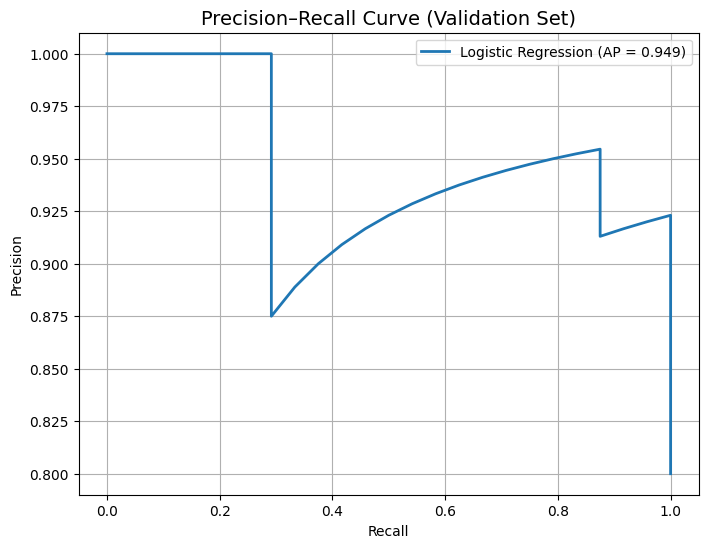

Accuracy:       0.8667
Precision:      0.8571
Recall:         1.0000
F1 Score:       0.9231
ROC-AUC:        0.8611

Confusion Matrix:
[[ 2  4]
 [ 0 24]]


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np

# Create classifier
classifier = LogisticRegression(random_state=0, max_iter=500, C=0.1)
classifier.fit(x_train, y_train.values.ravel())

# Use classifier on validation data
y_val_pred = classifier.predict(x_val)

# Get metrics of model on validation data (single-number metrics)
accuracy = accuracy_score(y_val.values.ravel(), y_val_pred)
precision = precision_score(y_val.values.ravel(), y_val_pred, average="binary")
recall = recall_score(y_val.values.ravel(), y_val_pred, average="binary")
f1 = f1_score(y_val.values.ravel(), y_val_pred, average="binary")
matrix = confusion_matrix(y_val.values.ravel(), y_val_pred)

y_val_proba = classifier.predict_proba(x_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_proba)

# ---------- Threshold vs Performance (Validation) ----------
thresholds = np.linspace(0, 1, 50)
precisions = []
recalls = []
f1s = []

y_val_true = y_val.values.ravel()

for t in thresholds:
    y_pred = (y_val_proba >= t).astype(int)
    precisions.append(precision_score(y_val_true, y_pred))
    recalls.append(recall_score(y_val_true, y_pred))
    f1s.append(f1_score(y_val_true, y_pred))

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Performance Metrics (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- ROC Curve (Validation) ----------
fpr, tpr, roc_thresholds = roc_curve(y_val.values.ravel(), y_val_proba)

# Compute ROC AUC from curve (should match roc_auc_score)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc_curve:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.title("ROC Curve for Parkinson's Classification (Validation Set)", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# ---------- Precision–Recall Curve (Validation) ----------
precisions_curve, recalls_curve, pr_thresholds = precision_recall_curve(
    y_val.values.ravel(), y_val_proba
)

ap = average_precision_score(y_val.values.ravel(), y_val_proba)

plt.figure(figsize=(8, 6))
plt.plot(recalls_curve, precisions_curve,
         label=f"Logistic Regression (AP = {ap:.3f})",
         linewidth=2)

plt.title("Precision–Recall Curve (Validation Set)", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.show()

# ---------- Print scalar metrics + confusion matrix ----------
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"ROC-AUC:        {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(matrix)


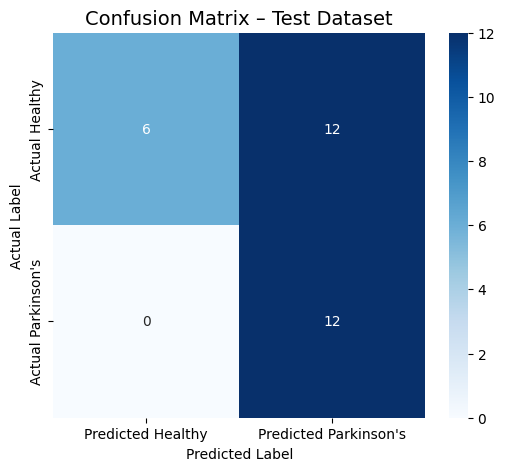

Threshold:      0.58
Accuracy:       0.6000
Precision:      0.5000
Recall:         1.0000
F1 Score:       0.6667
ROC-AUC:        0.9074

Confusion Matrix:
[[ 6 12]
 [ 0 12]]


In [4]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
)
import matplotlib.pyplot as plt
import seaborn as sns

# Retrain model on training + validation data
X_trainval = np.concatenate((x_train, x_val))
y_trainval = np.concatenate((y_train.values.ravel(), y_val.values.ravel()))

classifier = LogisticRegression(random_state=0, max_iter=500, C=0.1)
classifier.fit(X_trainval, y_trainval)

# Predict on test data
y_test_proba = classifier.predict_proba(x_test)[:, 1]

# Choose a custom threshold
threshold = 0.58
y_test_pred = (y_test_proba >= threshold).astype(int)

# Compute metrics
y_test_true = y_test.values.ravel()

accuracy  = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average="binary")
recall    = recall_score(y_test_true, y_test_pred, average="binary")
f1        = f1_score(y_test_true, y_test_pred, average="binary")
matrix    = confusion_matrix(y_test_true, y_test_pred)
roc_auc = roc_auc_score(y_test_true, y_test_proba)


# --- Confusion Matrix Heatmap---
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Healthy", "Predicted Parkinson's"],
            yticklabels=["Actual Healthy", "Actual Parkinson's"])

plt.title("Confusion Matrix – Test Dataset", fontsize=14)
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()



print(f"Threshold:      {threshold:.2f}")
print(f"Accuracy:       {accuracy:.4f}")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"ROC-AUC:        {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(matrix)
